# An√°lise de Corveng√™ncia de Munic√≠pios
## Daniel N. Rocha, Rafael Kovashikawa, Matheus Roman e Chen Zi
### Trabalho de Estat√≠stica ‚Äì FGV EPGE
O objetivo deste estudo √© realizar testes estat√≠sticos com dados emp√≠ricos do IBGE para testar a hip√≥tese de corverg√™ncia acerca da evolu√ß√£o do PIB dos munic√≠pios brasileiros. Isto √©, testaremos se os munic√≠pios com economia menor de fato cresceram mais rapidamente do que os que possuiam atividade econ√¥mica mais intensa.

Embora haja disponibilidade de dados a partir 1999, utilizamos o ano de 2002 como per√≠odo inicial, tendo em vista que houve mudan√ßa metodol√≥gica na coleta e agrega√ß√£o dos dados entre os anos de 1999 e 2002. Segundo o IBGE: 

"_Para os anos anteriores a 2010, cabe ressaltar, realizou-se a retropola√ß√£o dos dados at√© 2002, considerando-se a disponibilidade de informa√ß√µes para o per√≠odo, e estimou-se uma nova s√©rie, adaptada √†s altera√ß√µes da CNAE 2.0. [Classifica√ß√£o Nacional de Atividades Econ√¥micas - CNAE 2.0.]_"

A s√©rie temporal termina em 2017 pois √© o √∫ltimo ano de dados disponibilizados pelo IBGE. Dentro do recorte temporal selecionado √© poss√≠vel garantir que os dados s√£o compar√°veis entre si e "est√£o completamente integrados √†s s√©ries das Contas Nacionais e das Contas Regionais do Brasil".

In [39]:
%%capture
%pip install xlrd
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install palettable
%pip install matplotlib
%pip install jupyterthemes

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from scipy.stats import norm
import scipy
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color',
                'axes.titlesize','figure.figsize','legend.framealpha'],['white','white','white',
                'white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n
    
plt.rcParams['font.family'] = 'monospace'

## 1. Importando os Dados:
Todos os dados foram coletados do site do IBGE e podem ser consultados no seguinte link: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html

In [2]:
pib_cities_02_09 = pd.read_excel('PIB dos Municipios - base de dados 2002-2009.xls')
pib_cities_10_17 = pd.read_excel('PIB dos Municipios - base de dados 2010-2017.xls')

pib_cities = pd.concat([pib_cities_02_09, pib_cities_10_17], ignore_index=True).copy()

pib_cities = pib_cities[['Ano','Nome da Grande Regi√£o','Nome da Unidade da Federa√ß√£o','Nome do Munic√≠pio',
                         'C√≥digo do Munic√≠pio','Produto Interno Bruto per capita, \na pre√ßos correntes\n(R$ 1,00)',
                         'Valor adicionado bruto total, \na pre√ßos correntes\n(R$ 1.000)',
                         'Produto Interno Bruto, \na pre√ßos correntes\n(R$ 1.000)']]
pib_cities.rename(inplace=True, columns={'Produto Interno Bruto, \na pre√ßos correntes\n(R$ 1.000)':'PIB',
                              'Valor adicionado bruto total, \na pre√ßos correntes\n(R$ 1.000)':'Valor adicionado',
                              'Produto Interno Bruto per capita, \na pre√ßos correntes\n(R$ 1,00)':'PIB per capita',
                              'Nome da Grande Regi√£o':'Regi√£o','Nome da Unidade da Federa√ß√£o':'UF',
                              'Nome do Munic√≠pio':'Munic√≠pio'})

codigos_cidades = pib_cities[['Munic√≠pio','C√≥digo do Munic√≠pio']].drop_duplicates()
# salvando a tabela para retirar a coluna de codigo de municipio da analise sem perdas de dados

AMCs_dict = {'Figueir√£o': 'Camapu√£', 'Costa Rica': 'Camapu√£', 'Para√≠so das √Åguas': 'Camapu√£', '√Ågua Clara': 'Camapu√£',  # Camapu√£
             'Ipiranga do Norte': 'Tapurah','Itanhang√°': 'Tapurah',                                                     # Tapurah
             'Moju√≠ dos Campos': 'Santar√©m',                                                                            # Santar√©m
             'Aroeiras do Itaim': 'Picos',                                                                              # Picos
             'Naz√°ria': 'Teresina',                                                                                     # Teresina
             'Pescaria Brava': 'Laguna',                                                                                # Laguna
             'Balne√°rio Rinc√£o': 'I√ßara',                                                                               # I√ßara
             'Pinto Bandeira': 'Bento Gon√ßalves'}                                                                       # Bento Gon√ßalves
tratamento_AMCs = pib_cities['Munic√≠pio'].map(AMCs_dict).fillna(pib_cities['Munic√≠pio'])
pib_cities['Munic√≠pio'] = tratamento_AMCs

pib_cities['Popula√ß√£o'] = pib_cities['PIB']/pib_cities['PIB per capita']
pib_cities = pib_cities.drop('C√≥digo do Munic√≠pio', axis=1)

pib_cities = pib_cities.drop('PIB per capita', axis=1)
pib_cities = pib_cities.groupby(['Ano', 'Regi√£o', 'UF', 'Munic√≠pio'], as_index=False).sum()
pib_cities['PIB per capita'] = pib_cities['PIB'] / pib_cities['Popula√ß√£o']
pib_cities

Ano        Regi√£o                UF         Munic√≠pio  \
0      2002  Centro-oeste  Distrito Federal          Bras√≠lia   
1      2002  Centro-oeste             Goi√°s   Abadia de Goi√°s   
2      2002  Centro-oeste             Goi√°s         Abadi√¢nia   
3      2002  Centro-oeste             Goi√°s           Acre√∫na   
4      2002  Centro-oeste             Goi√°s         Adel√¢ndia   
...     ...           ...               ...               ...   
88923  2017           Sul    Santa Catarina            Zort√©a   
88924  2017           Sul    Santa Catarina         √Ågua Doce   
88925  2017           Sul    Santa Catarina       √Åguas Frias   
88926  2017           Sul    Santa Catarina      √Åguas Mornas   
88927  2017           Sul    Santa Catarina  √Åguas de Chapec√≥   

       Valor adicionado         PIB  Popula√ß√£o  PIB per capita  
0           46975920.59 53902199.80    2180.41        24721.18  
1              18196.13    19813.14       5.58         3552.65  
2              35960.34    38866.89      12.04         3227.88  
3             225888.33   248595.28      19.52        12736.07  
4               7765.65     8201.22       2.50         3287.06  
...                 ...         ...        ...             ...  
88923          66175.80    69088.86       3.30        20936.02  
88924         277503.23   298261.42       7.15        41691.56  
88925          83015.99    93258.91       2.39        39069.51  
88926         128481.50   137159.02       6.30        21778.19  
88927          92916.20    97131.57       6.45        15070.84  

[88928 rows x 8 columns]

### Criando colunas de varia√ß√£o percentual

In [3]:
pib_cities.sort_values(['Munic√≠pio','UF','Ano'],inplace=True,ignore_index=True)

In [4]:
pib_cities['Regi√£o']
for i in ['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']:
    pib_cities['PC_'+i.split(' ')[-1]] = pib_cities.groupby(['Munic√≠pio','UF'])[i].apply(pd.Series.pct_change)

## 2. Plotando os Retornos:

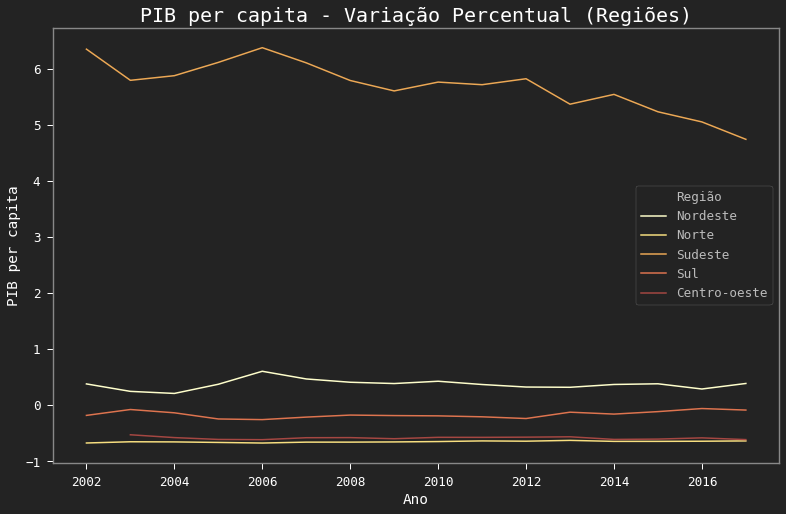

In [5]:
cmap = palettable.scientific.sequential.LaJolla_7.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Regi√£o']).sum()[['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']].reset_index().copy()
data=agg[['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']].pct_change().dropna().copy()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Regi√£o',agg['Regi√£o'])
sns.lineplot(data=data,x='Ano',y='PIB per capita',hue='Regi√£o',palette=cmap)
plt.title('PIB per capita - Varia√ß√£o Percentual (Regi√µes)');

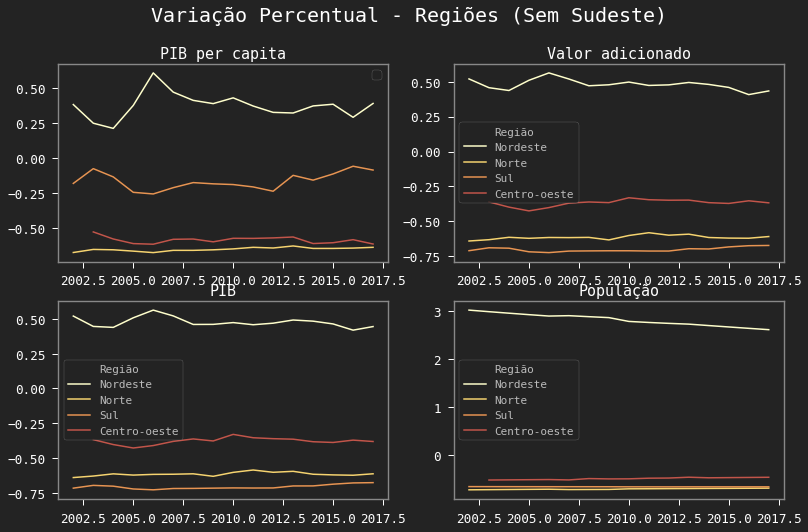

In [40]:
cmap = palettable.scientific.sequential.LaJolla_6.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Regi√£o']).sum()[['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']].reset_index()
data=agg[['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']].pct_change().dropna()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Regi√£o',agg['Regi√£o'])
data = data[data['Regi√£o']!='Sudeste']
k=1
for i in ['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']:
    plt.subplot(2,2,k)
    sns.lineplot(data=data,x='Ano',y=i,hue='Regi√£o',palette=cmap)
    plt.title(i,size=15)
    plt.xlabel('')
    plt.ylabel('')
    if k==1:
        plt.legend('')
    else:
        plt.legend(fontsize='small',loc='center left')
    k+=1
plt.suptitle("Varia√ß√£o Percentual - Regi√µes (Sem Sudeste)", color='w', fontsize=20);
# plt.tight_layout();

In [7]:
from ordered_set import OrderedSet
init_pib = list(np.repeat(np.nan,len(OrderedSet(zip(pib_cities.UF,pib_cities.Munic√≠pio))))) + list(
                np.tile([pib_cities[(pib_cities.UF==k)&(pib_cities.Munic√≠pio==m)&
                    (pib_cities.Ano==2002)]['PIB per capita'].values[0] 
                        for k,m in OrderedSet(zip(pib_cities.UF,pib_cities.Munic√≠pio))],15))

In [8]:
pib_cities.sort_values(['Ano','Munic√≠pio','UF'],inplace=True,ignore_index=True)
pib_cities['PIB_Inicial'] = init_pib
pib_cities.sort_values(['Munic√≠pio','UF','Ano'],inplace=True,ignore_index=True)
pib_cities

Ano        Regi√£o         UF        Munic√≠pio  Valor adicionado  \
0      2002  Centro-oeste      Goi√°s  Abadia de Goi√°s          18196.13   
1      2003  Centro-oeste      Goi√°s  Abadia de Goi√°s          21263.26   
2      2004  Centro-oeste      Goi√°s  Abadia de Goi√°s          22441.79   
3      2005  Centro-oeste      Goi√°s  Abadia de Goi√°s          26567.43   
4      2006  Centro-oeste      Goi√°s  Abadia de Goi√°s          29378.05   
...     ...           ...        ...              ...               ...   
88923  2013       Sudeste  S√£o Paulo             √ìleo          60428.10   
88924  2014       Sudeste  S√£o Paulo             √ìleo          77075.86   
88925  2015       Sudeste  S√£o Paulo             √ìleo          82658.79   
88926  2016       Sudeste  S√£o Paulo             √ìleo          89060.64   
88927  2017       Sudeste  S√£o Paulo             √ìleo          86883.20   

           PIB  Popula√ß√£o  PIB per capita  PC_capita  PC_adicionado  PC_PIB  \
0     19813.14       5.58         3552.65        nan            nan     nan   
1     22773.42       5.82         3915.65       0.10           0.17    0.15   
2     23756.06       6.05         3924.03       0.00           0.06    0.04   
3     28156.00       6.29         4473.47       0.14           0.18    0.19   
4     31164.65       6.53         4771.80       0.07           0.11    0.11   
...        ...        ...             ...        ...            ...     ...   
88923 60506.29       2.68        22610.72       0.52           0.54    0.54   
88924 77226.41       2.65        29120.06       0.29           0.28    0.28   
88925 83199.18       2.63        31658.75       0.09           0.07    0.08   
88926 89878.69       2.60        34502.38       0.09           0.08    0.08   
88927 88221.06       2.58        34154.49      -0.01          -0.02   -0.02   

       PC_Popula√ß√£o  PIB_Inicial  
0               nan          nan  
1              0.04      3552.65  
2              0.04      3552.65  
3              0.04      3552.65  
4              0.04      3552.65  
...             ...          ...  
88923          0.02      6787.30  
88924         -0.01      6787.30  
88925         -0.01      6787.30  
88926         -0.01      6787.30  
88927         -0.01      6787.30  

[88928 rows x 13 columns]

In [9]:
pib_cities.PIB_Inicial = np.log(pib_cities.PIB_Inicial)

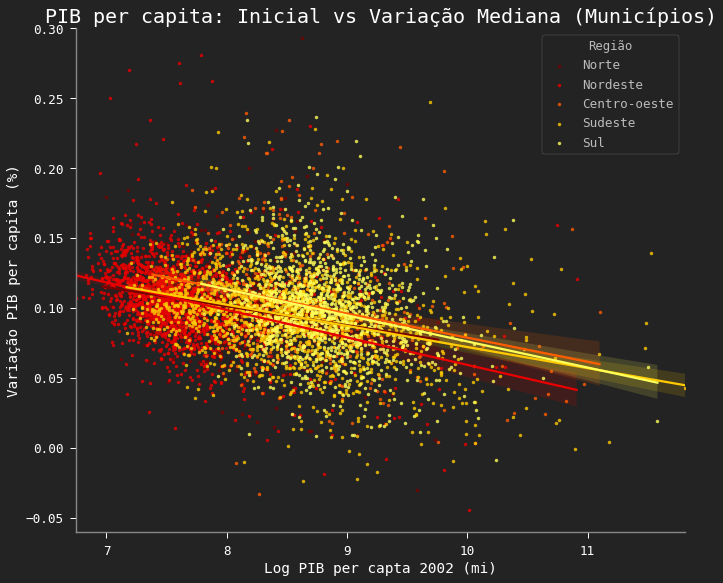

In [10]:
ax = sns.lmplot(x='PIB_Inicial',
                y='PC_capita',
                data=pib_cities.groupby(['UF','Munic√≠pio','Regi√£o'],as_index=False).median(),
                hue='Regi√£o',
                palette='hot',height=8,aspect=1.2,legend_out=False,scatter_kws={'s':12})
plt.xlabel('Log PIB per capta 2002 (mi)')
plt.ylabel('Varia√ß√£o PIB per capita (%)')
plt.ylim(-0.06,0.3)
plt.title('PIB per capita: Inicial vs Varia√ß√£o Mediana (Munic√≠pios)');

## 4. An√°lise por Cidade:
A varia√ß√£o proporcional (e n√£o absoluta) permite comparar o crescimento de cidades com economias de tamanhos distintos

In [11]:
def table_plot(restricao,show_table,show_plot):
    "Funcao auxiliar das demais funcoes abaixo. Faz ajustes na tabela e plota o grafico da cidade pedida"
    "Argumentos: restri√ß√£o gerada pelas outras fun√ß√µes"
    city=restricao[['PIB per capita','Valor adicionado','PIB','Popula√ß√£o']].pct_change().dropna()
    city.insert(0,'Ano',restricao['Ano'])
    city.insert(1,'Regi√£o',restricao['Regi√£o'])
    city.insert(2,'UF',restricao['UF'])
    city.insert(3,'Munic√≠pio',restricao['Munic√≠pio'])
#     city.insert(4,'Munic√≠pio',restricao['Munic√≠pio'])
    if show_plot==True:
        sns.lineplot(data=city,x='Ano',y='PIB per capita',label='PIB per capita')
        sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
        sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
        sns.lineplot(data=city,x='Ano',y='Popula√ß√£o',label='Popula√ß√£o')
        plt.title(restricao['Munic√≠pio'].values[0]+' - Crescimento Percentual do PIB')
    if show_table == True:
        return city

def pct_change_city_name_plot(regiao,uf,municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: macrorregiao (eg. Nordeste), unidade da federa√ß√£o (eg. Piau√≠) e municipio (eg. Teresina)"
    restricao = pib_cities[(pib_cities['Regi√£o']==regiao)&(pib_cities['UF']==uf)&(pib_cities['Munic√≠pio']==municipio)]
    return table_plot(restricao,show_table,show_plot)

def pct_change_city_name(nome_do_municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: codigo da cidade do IBGE (eg. Rio de Janeiro)"
    restricao = pib_cities[pib_cities['Munic√≠pio']==nome_do_municipio]
    return table_plot(restricao,show_table,show_plot)

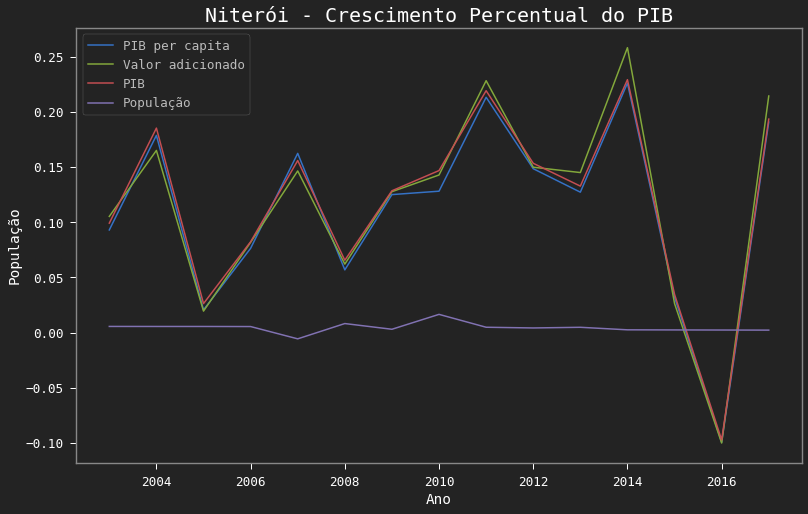

In [12]:
pct_change_city_name_plot('Sudeste', 'Rio de Janeiro', 'Niter√≥i')

In [13]:
pct_change_city_name('Bar√£o de Antonina',show_table=True,show_plot=False)

Ano   Regi√£o         UF          Munic√≠pio  PIB per capita  \
8209  2003  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.15   
8210  2004  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.05   
8211  2005  Sudeste  S√£o Paulo  Bar√£o de Antonina           -0.09   
8212  2006  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.26   
8213  2007  Sudeste  S√£o Paulo  Bar√£o de Antonina           -0.09   
8214  2008  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.12   
8215  2009  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.02   
8216  2010  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.05   
8217  2011  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.15   
8218  2012  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.12   
8219  2013  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.07   
8220  2014  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.83   
8221  2015  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.03   
8222  2016  Sudeste  S√£o Paulo  Bar√£o de Antonina            0.11   
8223  2017  Sudeste  S√£o Paulo  Bar√£o de Antonina           -0.01   

      Valor adicionado   PIB  Popula√ß√£o  
8209              0.14  0.14      -0.01  
8210              0.03  0.04      -0.01  
8211             -0.09 -0.10      -0.01  
8212              0.24  0.25      -0.01  
8213             -0.04 -0.05       0.05  
8214              0.14  0.15       0.03  
8215              0.03  0.02       0.00  
8216              0.18  0.16       0.10  
8217              0.16  0.16       0.01  
8218              0.12  0.13       0.01  
8219              0.11  0.12       0.04  
8220              0.74  0.85       0.01  
8221              0.04  0.04       0.01  
8222              0.14  0.12       0.01  
8223             -0.01 -0.01       0.01

## Conclus√£o:

> ### blah blah

<br>

---
---

---

## Exerc√≠cio 2

    Uma das formas de testar converg√™ncia √© testar por ùúé-converg√™ncia: de que, de uma data passada at√© uma data subsequente, houve uma redu√ß√£o da vari√¢ncia do PIB per capita. Use um teste de vari√¢ncia para testar essa hip√≥tese. Explicite o teste e indique o intervalo de confian√ßa, a estat√≠stica de teste, e o valor p.
    
Supondo que a amostra √© grande o suficiente para assumir normalidade, iremos construir nosso teste de hip√≥tese como abaixo, usando um $\alpha$ de 10%. Isto √©, a hip√≥tese nula ($\text{H}_0$) sugere que n√£o h√° converg√™ncia.

### $$ H_0: \frac{\sigma_1^2}{\sigma_2^2} = 1 \ \ \ \text{X} \ \ \ H_1: \frac{\sigma_1^2}{\sigma_2^2} > 1 $$

### $$ \text{IC}: \ \ \frac{\sigma_2^2}{\sigma_1^2} = \bigg[ 0;\ \frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ N_2-1;\ N_1-1;\ 1-\alpha} \bigg] $$

### $$ \text{RC}: \ \ \bigg[\text{F}_{\ N_2-1;\ N_1-1;\ \alpha }; \ +‚àû \bigg) $$

* Construindo e observando as tabelas de estat√≠sticas descritivas de cada ano:

In [14]:
pib_cities_2002 = pib_cities[pib_cities['Ano'] == 2002]

var_2002 = np.var(pib_cities_2002['PIB per capita'])

pib_cities_2002.describe()

Ano  Valor adicionado          PIB  Popula√ß√£o  PIB per capita  \
count 5558.00           5558.00      5558.00    5558.00         5558.00   
mean  2002.00         228538.08    267863.85      31.74         5302.13   
std      0.00        2530955.38   3075019.03     190.96         6029.05   
min   2002.00           2322.97      2384.28       0.81          853.31   
25%   2002.00          16160.70     16836.87       5.06         2155.48   
50%   2002.00          34479.68     36263.44      10.42         3863.47   
75%   2002.00          84824.44     91925.25      21.69         6462.39   
max   2002.00      155035187.59 188706118.97   10660.59       134623.26   

       PC_capita  PC_adicionado  PC_PIB  PC_Popula√ß√£o  PIB_Inicial  
count       0.00           0.00    0.00          0.00         0.00  
mean         nan            nan     nan           nan          nan  
std          nan            nan     nan           nan          nan  
min          nan            nan     nan           nan          nan  
25%          nan            nan     nan           nan          nan  
50%          nan            nan     nan           nan          nan  
75%          nan            nan     nan           nan          nan  
max          nan            nan     nan           nan          nan

In [15]:
pib_cities_2017 = pib_cities[pib_cities['Ano'] == 2017]

var_2017 = np.var(pib_cities_2017['PIB per capita'])

pib_cities_2017.describe()

Ano  Valor adicionado          PIB  Popula√ß√£o  PIB per capita  \
count 5558.00           5558.00      5558.00    5558.00         5558.00   
mean  2017.00        1020109.03   1184476.25      37.36        21950.39   
std      0.00        9581035.44  11634293.19     218.64        20877.31   
min   2017.00          12716.17     12992.84       0.81         3285.04   
25%   2017.00          75576.58     79101.86       5.51         9480.65   
50%   2017.00         166172.12    176621.24      11.64        16592.08   
75%   2017.00         434031.37    470221.54      25.37        27045.98   
max   2017.00      576762105.78 699288352.21   12106.92       344847.17   

       PC_capita  PC_adicionado  PC_PIB  PC_Popula√ß√£o  PIB_Inicial  
count    5558.00        5558.00 5558.00       5558.00      5558.00  
mean        0.06           0.06    0.06          0.00         8.28  
std         0.19           0.19    0.20          0.01         0.73  
min        -0.72          -0.73   -0.72         -0.22         6.75  
25%        -0.01          -0.01   -0.00          0.00         7.68  
50%         0.04           0.05    0.05          0.00         8.26  
75%         0.09           0.10    0.10          0.01         8.77  
max         7.83           6.53    8.00          0.09        11.81

* Desenvolvendo a estat√≠stica de teste F:

In [16]:
F_0 = var_2017 / var_2002

df2002 = len(pib_cities_2002) - 1

df2017 = len(pib_cities_2017) - 1

print('\n f_0: ', F_0, '\n')


 f_0:  11.990866715679216 



In [18]:
alpha = 0.1 #Or whatever you want your alpha to be.
p_value = scipy.stats.f.cdf(F_0,df2002, df2017)

print('\n')

if p_value > alpha:    
    print('N√£o rejeitamos a Hip√≥tese Nula em que Var(X) == Var(Y), √† um alpha de ', alpha, '\n')
    
else:
    print('Rejeitamos a Hip√≥tese Nula em que Var(X) == Var(Y), √† um alpha de ', alpha, '\n')

print('Com um P‚Äìvalor de: ', p_value, '\n')



N√£o rejeitamos a Hip√≥tese Nula em que Var(X) == Var(Y), √† um alpha de  0.1 

Com um P‚Äìvalor de:  0.9999999999999999 



---

### $$ \text{p-valor} : \mathbb P (Z ‚â• z_0) = 0 $$

#### $$ z_0: \text{valor observado da estat√≠stica do teste} $$

---

In [19]:
1-scipy.stats.f.cdf(alpha, df2002, df2017)

1.0

### $$ \implies \text{RC}: \ \ \bigg[\text{F}_{\ 5557;\ 5557;\ 0.1 }; \ ‚àû \bigg) $$

### $$ \implies \text{RC}: \  \bigg[ 1; \ ‚àû \bigg) $$

### $$ \text{f}_0 = 11.990866715679216  \therefore \text{f}_0 \in \text{RC} $$

‚Ä¢ Como W est√° dentro da Regi√£o Cr√≠tica, iremos rejeitar a hip√≥stese nula!

---

### $$ \text{IC} \bigg(\frac{\sigma_2^2}{\sigma_1^2}\bigg) = \bigg[ 0;\ \frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ 5557;\ 5557;\ 0.9} \bigg] $$

In [20]:
F_0 * (1 - scipy.stats.f.cdf(alpha,df2002, df2017))

11.990866715679216

### $$ \implies \text{IC} \bigg(\frac{\sigma_2^2}{\sigma_1^2}\bigg) = \bigg[ 0;\ 0.08339680722932259 \bigg] $$

‚Ä¢ construindo a IC a partir da estat√≠stica de teste, obtemos o intervalo de confian√ßa acima

---

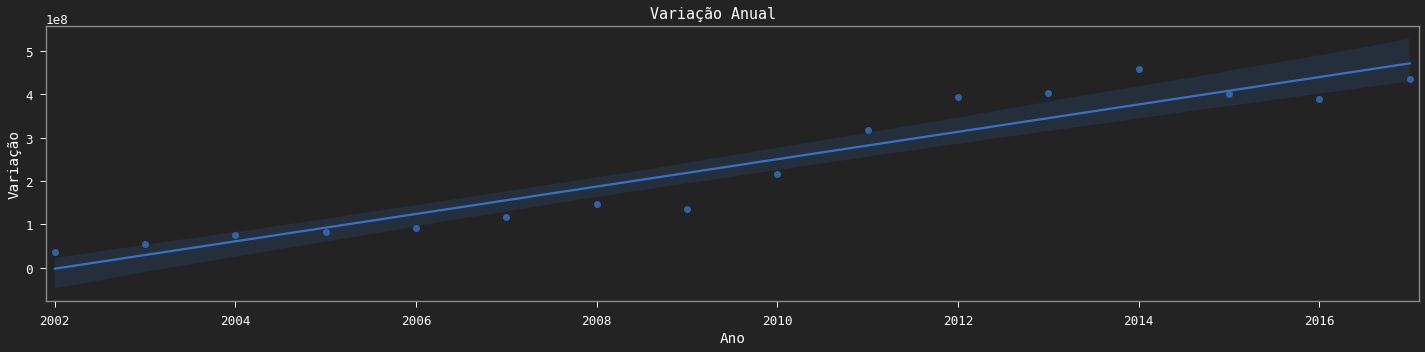

In [21]:
anos    = []
var_ano = []

for ano in pib_cities['Ano'].unique():
    
    anos.append(ano)
    
    var_no_ano = np.var(pib_cities[pib_cities['Ano'] == ano]['PIB per capita'])
    
    var_ano.append(var_no_ano)

df_ano_var = pd.DataFrame({'ano': anos, 'var_ano': var_ano})

plt.figure(figsize=(20,5))
ax = sns.regplot(data=df_ano_var, x="ano", y="var_ano")
plt.xlabel('Ano')
plt.ylabel('Varia√ß√£o')
plt.suptitle("Varia√ß√£o Anual", color='w', fontsize=15)
ax.set_xlim([2001.9,2017.1])
plt.tight_layout();

### Conclus√£o:


> #### Supondo n√£o haver estacionariedade e rejeitando a hip√≥tese nula em que n√£o h√° sigma converg√™ncia, como demonstramos acima, fica bem claro o resultado; Tamb√©m encontramos no gr√°fico acima, onde observamos que a tend√™ncia √© de um aumento da varia√ß√£o do PIB per capita ao passar dos anos.

<br>

---

---

---

# Quest√£o 3

    Tamb√©m √© poss√≠vel testar por converg√™ncia ao comparar o crescimento de duas sub-amostras de munic√≠pios: uma inicialmente mais pobre, outra inicialmente mais rica. Use um teste de m√©dias para examinar converg√™ncia. Explicite o teste e indique o intervalo de confian√ßa, a estat√≠stica de teste, e o valor p. Tamb√©m explicite as suas decis√µes de como definir as sub-amostras.


Como podemos ver nas tabelas abaixo, 96% das 100 cidades mais pobres em 2002, o in√≠cio da nossa amostragem, s√£o Nordestisnas; Algo que explicita a grande desigualdade regional brasileira. N√£o obstante, o Norte possui 0% dentro das 100 cidades mais ricas.

Desta forma, decidimos coletar a sub-amostra olhando para as 20 cidades mais ricas ou pobres dentro de cada regi√£o, de forma a contemplar todas as realidades desse imenso pa√≠s.

OBS.: Exclu√≠mos a cidade de Guamar√©, RN, pois em 2012 teve um PIB negativo dado √† varia√ß√£o do pre√ßo do barril do petr√≥leo o que fez seu crescimento percentual dos seguintes anos virarem grandes outliers.

Fonte: http://www.tribunadonorte.com.br/noticia/pib-potiguar-se-concentra-em-tra-s-munica-pios/333514

In [22]:
pib_cities_2002.nlargest(100, 'PIB per capita').groupby('Regi√£o').count()[['Munic√≠pio']].T

Regi√£o     Centro-oeste  Nordeste  Sudeste  Sul
Munic√≠pio            20         7       55   18

In [23]:
pib_cities_2002.nsmallest(100, 'PIB per capita').groupby('Regi√£o').count()[['Munic√≠pio']].T

Regi√£o     Nordeste  Norte
Munic√≠pio        96      4

In [24]:
df_ricas = pd.DataFrame(columns=['Munic√≠pio', 'UF'])

for regiao_ in pib_cities_2002['Regi√£o'].unique():

    temp__ = pib_cities_2002[pib_cities_2002['Regi√£o'] == regiao_]
    temp__ = temp__[temp__['Munic√≠pio'] != 'Guamar√©']         # http://www.tribunadonorte.com.br/noticia/pib-potiguar-se-concentra-em-tra-s-munica-pios/333514
    temp__ = temp__.nlargest(20, 'PIB per capita')[['Munic√≠pio', 'UF', 'PIB per capita']]
    
    df_ricas = df_ricas.append(temp__)
    
df_ricas.columns = ['Munic√≠pio', 'UF', 'PIB per capita (2002)']

df_ricas = pd.merge(pib_cities,df_ricas.drop_duplicates())

df_pobres = pd.DataFrame(columns=['Munic√≠pio', 'UF'])

for regiao_ in pib_cities_2002['Regi√£o'].unique():

    temp__ = pib_cities_2002[pib_cities_2002['Regi√£o'] == regiao_]
    temp__ = temp__.nsmallest(20, 'PIB per capita')[['Munic√≠pio', 'UF', 'PIB per capita']]
    
    df_pobres = df_pobres.append(temp__)
    
df_pobres.columns = ['Munic√≠pio', 'UF', 'PIB per capita (2002)']

df_pobres = pd.merge(pib_cities,df_pobres.drop_duplicates())

In [25]:
df_pobres.describe()

Ano  Valor adicionado        PIB  Popula√ß√£o  PIB per capita  \
count 1600.00           1600.00    1600.00    1600.00         1600.00   
mean  2009.50         114182.45  122198.26      21.19         5484.35   
std      4.61         243022.78  266274.83      32.22         4218.73   
min   2002.00           3941.48    4031.72       2.19          853.31   
25%   2005.75          23034.52   23893.80       6.65         2594.22   
50%   2009.50          43257.52   45013.58      10.65         4338.15   
75%   2013.25          88156.98   91167.10      19.51         6854.49   
max   2017.00        2396159.46 2609696.15     214.95        40653.91   

       PC_capita  PC_adicionado  PC_PIB  PC_Popula√ß√£o  PIB_Inicial  \
count    1500.00        1500.00 1500.00       1500.00      1500.00   
mean        0.14           0.13    0.13          0.00         7.40   
std         0.18           0.13    0.13          0.08         0.40   
min        -0.57          -0.36   -0.35         -0.77         6.75   
25%         0.06           0.07    0.07         -0.00         7.13   
50%         0.12           0.12    0.12          0.01         7.30   
75%         0.18           0.18    0.19          0.02         7.82   
max         3.88           1.90    1.88          1.92         8.04   

       PIB per capita (2002)  
count                1600.00  
mean                 1771.33  
std                   703.01  
min                   853.31  
25%                  1253.96  
50%                  1474.64  
75%                  2493.82  
max                  3112.79

In [26]:
df_ricas.describe()

Ano  Valor adicionado          PIB  Popula√ß√£o  PIB per capita  \
count 1600.00           1600.00      1600.00    1600.00         1600.00   
mean  2009.50        3580903.87   4288156.20      88.49        58803.45   
std      4.61       13874928.11  16273319.49     316.20        51184.24   
min   2002.00        -510593.06      9828.73       1.21         3765.32   
25%   2005.75         277491.62    306596.55       6.51        24714.41   
50%   2009.50         680115.08    731143.01      17.20        45049.32   
75%   2013.25        1906096.92   2316826.85      49.89        75008.03   
max   2017.00      215562327.90 244682756.47    3039.44       364529.33   

       PC_capita  PC_adicionado  PC_PIB  PC_Popula√ß√£o  PIB_Inicial  \
count    1500.00        1500.00 1500.00       1500.00      1500.00   
mean        0.09           0.12    0.12          0.02        10.12   
std         0.27           0.32    0.27          0.06         0.70   
min        -0.80          -3.19   -0.79         -0.30         8.80   
25%        -0.05          -0.03   -0.02          0.01         9.61   
50%         0.07           0.10    0.09          0.02        10.10   
75%         0.20           0.23    0.22          0.03        10.57   
max         2.25           5.32    2.23          0.95        11.81   

       PIB per capita (2002)  
count                1600.00  
mean                31512.72  
std                 24055.46  
min                  6646.64  
25%                 14863.31  
50%                 24356.19  
75%                 38962.28  
max                134623.26

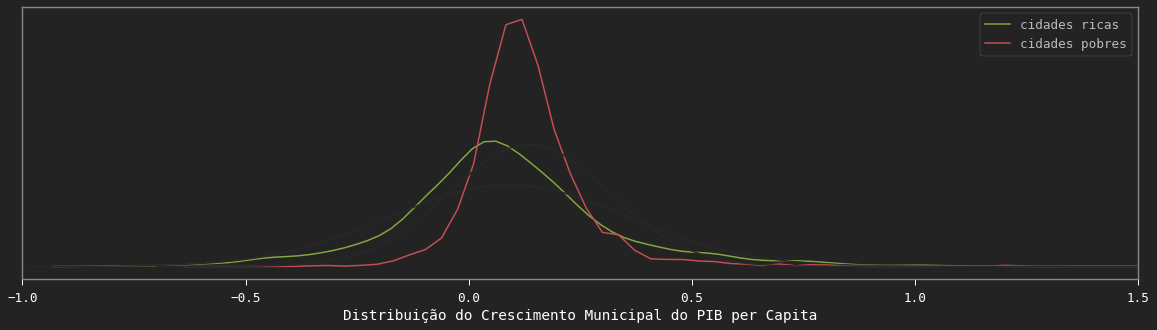

In [48]:
plt.figure(figsize=(20,5))

ax = sns.distplot(df_ricas['PC_capita'], hist=False, fit=norm, color='g', label='cidades ricas')
bx = sns.distplot(df_pobres['PC_capita'], hist=False, fit=norm, color='r', label='cidades pobres')
ax.set_xlim([-1, 1.5])
plt.xlabel('Distribui√ß√£o do Crescimento Municipal do PIB per Capita')

plt.yticks([]);

> ### Com as sub-amostras selecionadas, podemos prosseguir com o teste de hip√≥tese para confrontar a m√©dia de crescimento de munic√≠pios inicialmente mais ricos contra os mais pobres. Montamos da seguinte maneira abaixo, isto √©, formulando uma hip√≥tese alternativa ($\text{H}_1$) em que o crescimento m√©dio das cidades mais pobres √© maior que o de cidades mais ricas no per√≠odo de observa√ß√£o:

### $$ \text{H}_0: \mu_p - \mu_r = 0 \ \ \ \text{X} \ \ \ \text{H}_1: \mu_p - \mu_r > 0 $$

### $$ T = \frac{ \overline{X}_p - \overline{X}_r }{ \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r} } } $$

### $$ S_p = \sqrt{ \frac{ (n_p - 1) s_p^2 + (n_r - 1) s_2^2 }{ n_p + n_r - 2 } } $$

### verificar se $ T \in \text{RC} $:

### $$ \text{RC} = \ \ \bigg[\text{t}_{\ n_p + n_r - 2;\ \alpha }; \ +‚àû \bigg) $$

### verificar se $ T \in \text{IC} $:

### $$ \text{IC}_{100(1-\alpha)\% } (\mu_p - \mu_r) = \ \ \Bigg[ (\overline{X}_p - \overline{X}_r) - \text{t}_{\ n_p + n_r - 2;\ \frac{\alpha}{2}} \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r}  }; \ (\overline{X}_p - \overline{X}_r) + \text{t}_{\ n_p + n_r - 2;\ \frac{\alpha}{2}} \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r}  } \Bigg] $$

In [28]:
df_ricas['PC_capita'].mean()

0.09056226004595594

In [29]:
df_pobres['PC_capita'].mean()

0.13557706626498073

In [33]:
n_1 = len(df_ricas['Munic√≠pio'].unique())

n_2 = len(df_pobres['Munic√≠pio'].unique())

S_p = np.sqrt( n_1 * df_ricas['PC_capita'].var() + n_2 * df_pobres['PC_capita'].var() ) / np.sqrt( n_1 + n_2 - 2 )

T_0 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) / ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

dist_t = 1.28



print('n_1 \t = ', n_1)

print('n_2 \t = ', n_2)

print('S_p \t = ', S_p)

print('t_0  \t = ', T_0)

print('RC  \t =  [{:.5f}; +‚àû)'.format(dist_t))

n_1 	 =  100
n_2 	 =  100
S_p 	 =  0.22901384286529827
t_0  	 =  1.3898843114908463
RC  	 =  [1.28000; +‚àû)


In [32]:
# calculate the critical value
alpha = 0.05
cv = scipy.stats.t.ppf(1.0 - 0.05, n_1 + n_2 - 2)
cv_1 = 1.645

p = (1 - scipy.stats.t.cdf(abs(T_0), n_1 + n_2 - 2))

print('\n p‚Äìvalor = ', p, '\n')

ic_0 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) - cv_1 * ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

ic_1 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) + cv_1 * ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

print('\n IC = [{}; {}]'.format(ic_0, ic_1), '\n')


 p‚Äìvalor =  0.08306233519031203 


 IC = [-0.008262546160661709; 0.0982921585987113] 



## Conclus√£o:

> ### Como observamos nos testes acima, √© poss√≠vel dizer que a hip√≥tese nula ser√° rejeitada ao n√≠vel de signific√¢ncia 0.1, visto que a estat√≠stica de teste ($\text{t}_0$) pertence √† Regi√£o Cr√≠tica.

<br>

---

---

---

# Quest√£o 4

    Estime uma regress√£o linear de crescimento municipal no per√≠odo contra o PIB per capita inicial. Escolha a data de an√°lise e o ano inicial de forma consistente com as perguntas anteriores. Reporte a estimativa para o intercepto, o coeficiente linear, e os intervalos de confian√ßa.
    
Utilizamos uma transforma√ß√£o logar√≠timica para comparar o crescimento dos munic√≠pios de forma justa - podendo ajudar a deixar a rela√ß√£o entre os dados mais clara; n√£o obstante, definiremos como o crescimento do PIB a varia√ß√£o percentual do crescimento entre os anos de 2002 √† 2017, como mostrado no gr√°fico:

# $$ Y_{\text{crescimento do PIB}} = \alpha + \beta\ \log \big(X_{\text{PIB per capita } 2002}\big) + \epsilon $$

# $$ \implies Y_{\text{crescimento do PIB}} = \frac{X_{\text{PIB } 2017} - X_{\text{PIB } 2002}}{X_{\text{PIB } 2002}} $$

In [34]:
names = pib_cities_2002.columns.tolist()
names[names.index('PIB per capita')] = 'PIB per capita (2002)'
names[names.index('PIB')] = 'PIB (2002)'
pib_cities_2002.columns = names

pib_cities_2002 = pib_cities_2002[['Regi√£o', 'UF', 'Munic√≠pio',
                                   'PIB (2002)', 'PIB per capita (2002)']]

pib_cities_2002.describe()

PIB (2002)  PIB per capita (2002)
count      5558.00                5558.00
mean     267863.85                5302.13
std     3075019.03                6029.05
min        2384.28                 853.31
25%       16836.87                2155.48
50%       36263.44                3863.47
75%       91925.25                6462.39
max   188706118.97              134623.26

In [35]:
names = pib_cities_2017.columns.tolist()
names[names.index('PIB per capita')] = 'PIB per capita (2017)'
names[names.index('PIB')] = 'PIB (2017)'
pib_cities_2017.columns = names

pib_cities_2017 = pib_cities_2017[['Regi√£o', 'UF', 'Munic√≠pio',
                                   'PIB (2017)', 'PIB per capita (2017)']]

pib_cities_2017.describe()

PIB (2017)  PIB per capita (2017)
count      5558.00                5558.00
mean    1184476.25               21950.39
std    11634293.19               20877.31
min       12992.84                3285.04
25%       79101.86                9480.65
50%      176621.24               16592.08
75%      470221.54               27045.98
max   699288352.21              344847.17

In [36]:
df_regression = pd.merge(pib_cities_2002,pib_cities_2017)

df_regression['Crescimento do PIB'] = (df_regression['PIB (2017)'] - df_regression['PIB (2002)']) / df_regression['PIB (2002)']

df_regression

Regi√£o                 UF            Munic√≠pio  PIB (2002)  \
0     Centro-oeste              Goi√°s      Abadia de Goi√°s    19813.14   
1          Sudeste       Minas Gerais  Abadia dos Dourados    23198.70   
2     Centro-oeste              Goi√°s            Abadi√¢nia    38866.89   
3            Norte               Par√°           Abaetetuba   224354.00   
4          Sudeste       Minas Gerais               Abaet√©    93248.63   
...            ...                ...                  ...         ...   
5553           Sul  Rio Grande do Sul                √Åurea    19818.92   
5554           Sul             Paran√°               √Çngulo    17361.65   
5555      Nordeste              Bahia        √ârico Cardoso    16660.85   
5556         Norte               Par√°               √ìbidos   131235.12   
5557       Sudeste          S√£o Paulo                 √ìleo    20694.47   

      PIB per capita (2002)  PIB (2017)  PIB per capita (2017)  \
0                   3552.65   233954.42               28506.69   
1                   3606.20   154969.41               21953.45   
2                   3227.88   303352.18               16157.24   
3                   1799.79  1337194.37                8718.18   
4                   4082.69   426041.74               18044.21   
...                     ...         ...                    ...   
5553                5182.77    96974.68               26082.49   
5554                5851.58    99192.77               33353.32   
5555                1330.84    60639.49                5408.45   
5556                2751.78   624484.81               12310.70   
5557                6787.30    88221.06               34154.49   

      Crescimento do PIB  
0                  10.81  
1                   5.68  
2                   6.80  
3                   4.96  
4                   3.57  
...                  ...  
5553                3.89  
5554                4.71  
5555                2.64  
5556                3.76  
5557                3.26  

[5558 rows x 8 columns]

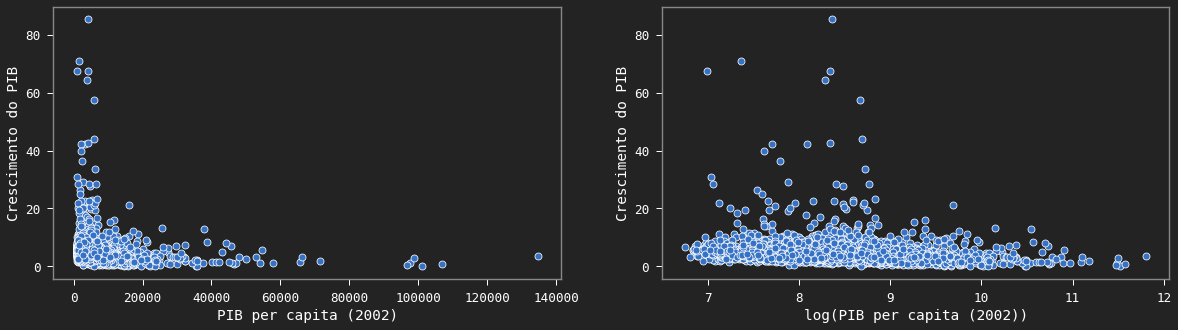

In [37]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)

sns.scatterplot(df_regression['PIB per capita (2002)'], df_regression['Crescimento do PIB'])

df_regression['log(PIB per capita (2002))'] = np.log(df_regression['PIB per capita (2002)'])

plt.subplot(1, 2, 2)

sns.scatterplot(df_regression['log(PIB per capita (2002))'], df_regression['Crescimento do PIB']);

In [41]:
X = np.log(np.reshape(df_regression['PIB per capita (2002)'].tolist(), (5558, 1)))

Y = df_regression['Crescimento do PIB'].tolist()

regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('\n Intercepto: \n', regr.intercept_)
print('\n Coeficiente: \n', regr.coef_[0])
X = sm.add_constant(X)
Y=list(Y)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)


 Intercepto: 
 9.490911835383127

 Coeficiente: 
 -0.62865162095592
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     102.5
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           7.02e-24
Time:                        20:45:14   Log-Likelihood:                -14623.
No. Observations:                5558   AIC:                         2.925e+04
Df Residuals:                    5556   BIC:                         2.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

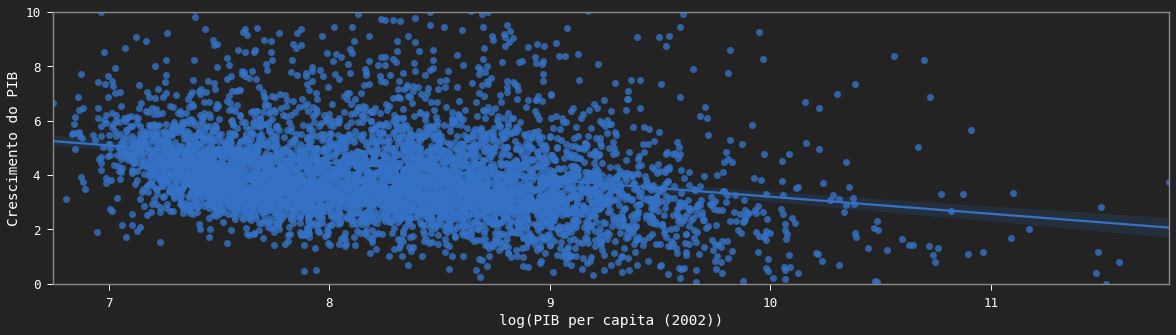

In [42]:
plt.figure(figsize=(20,5))

ax = sns.regplot(np.log(np.reshape(df_regression['PIB per capita (2002)'].tolist(), (5558, 1))), df_regression['Crescimento do PIB'].tolist())

ax.set_ylim([0, 10])

plt.xlabel('log(PIB per capita (2002))')

plt.ylabel('Crescimento do PIB');

## Conclus√£o:

> ### A partir da regress√£o acima √© poss√≠vel observar que o crescimento do PIB no per√≠odo da amostra √© negativamente correlacionado com o PIB per capita de 2002, algo que condiz com os resultados das quest√µes anteriores. N√£o obstante, devemos observar que o $\text{R}^2$ obtido possui baixo poder explicativo que pode ser entendido como um sintoma de que falta outras vari√°veis na regress√£o. Nos resultados da OLS, tamb√©m temos os intervalos de confian√ßa para o coeficiente linear ($\beta$) e o intercepto ($\alpha$).


---
---
---